In [16]:
# ===== INSTALL และ IMPORT LIBRARIES =====
!pip install datasets transformers torch scikit-learn tree-sitter sentencepiece
!pip install numpy pandas matplotlib seaborn tqdm
# สำหรับ tree-sitter
!pip install tree-sitter-cpp tree-sitter-languages

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 506.3/506.3 kB 37.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.0/12.0 MB 120.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 627.7/627.7 kB 75.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 59.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 193.2/193.2 kB 39.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.7/42.7 MB 56.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 564.3/564.3 kB 84.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 25.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 73.5/73.5 kB 17.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.3/3.3 MB 130.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 485.8/485.8 kB 79.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 145.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [19]:
# ===== IMPORT LIBRARIES และ SETUP =====
import os
import re
import warnings
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
from pathlib import Path

# Hugging Face & ML libraries
from datasets import load_dataset
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.preprocessing import normalize
from sklearn.metrics import precision_recall_curve, f1_score, classification_report
from sklearn.metrics import precision_score, recall_score, accuracy_score, confusion_matrix
from sklearn.model_selection import train_test_split

# Tree-sitter imports
import tree_sitter_cpp as tscpp
from tree_sitter import Language, Parser

# Configuration
warnings.filterwarnings('ignore')
np.random.seed(42)

print("📚 Libraries imported successfully!")
print("🌲 Tree-sitter setup ready for C++ parsing")

/root/venv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
📚 Libraries imported successfully!
🌲 Tree-sitter setup ready for C++ parsing


In [22]:
# ===== โหลด DATASET เหมือน Plag01 Notebook =====
# โหลด Google's Code Clone Detection Dataset จาก POJ-104
dataset = load_dataset("google/code_x_glue_cc_clone_detection_poj104")
print(f"Dataset info:")
print(f"   - Splits: {list(dataset.keys())}")
print(f"   - Train samples: {len(dataset['train'])}")
print(f"   - Validation samples: {len(dataset['validation'])}")  
print(f"   - Test samples: {len(dataset['test'])}")
print(f"   - Columns: {dataset['train'].column_names}")

# ตรวจสอบ sample
sample = dataset['train'][0]
print(f"\n🔍 Sample data structure:")
for key, value in sample.items():
    if isinstance(value, str):
        print(f"   {key}: '{value[:100]}{'...' if len(value) > 100 else ''}'")
    else:
        print(f"   {key}: {value}")

Generating test split: 100%|██████████| 12000/12000 [00:00<00:00, 564610.61 examples/s]Dataset info:
   - Splits: ['train', 'validation', 'test']
   - Train samples: 32500
   - Validation samples: 8500
   - Test samples: 12000
   - Columns: ['id', 'code', 'label']

🔍 Sample data structure:
   id: 0
   code: 'int numcount=0;
void divide(int num,int x)
{
	int i;
	if(num==1)
		numcount++;
	for(i=x;i<=num...'
   label: '1'



In [25]:
# ===== สร้าง BALANCED DATASET เหมือน Plag01 Notebook =====
N_SAMPLES = 1000      # จำนวน sample รวม
N_PROBLEMS = 10       # จำนวน problems
SAMPLES_PER_PROBLEM = N_SAMPLES // N_PROBLEMS
N_PAIRS = 1500        # จำนวน pairs สำหรับเปรียบเทียบ

train_data = dataset['train']

print(f"🎯 Target Configuration:")
print(f"   - Total samples: {N_SAMPLES}")
print(f"   - Number of problems: {N_PROBLEMS}")
print(f"   - Samples per problem: {SAMPLES_PER_PROBLEM}")
print(f"   - Total pairs to create: {N_PAIRS}")

# สำรวจ labels และเลือก problems
all_labels = set()
label_counts = {}

for i in range(min(5000, len(train_data))):
    label = int(train_data[i]['label'])
    all_labels.add(label)
    if label not in label_counts:
        label_counts[label] = 0
    label_counts[label] += 1

# เรียงลำดับ problems ตาม sample count
sorted_problems = sorted(label_counts.items(), key=lambda x: x[1], reverse=True)
selected_problems = [label for label, count in sorted_problems[:N_PROBLEMS]]

print(f"\n✅ Selected {N_PROBLEMS} problems: {selected_problems}")

# เลือก samples จาก selected problems
selected_indices = []
for problem_id in selected_problems:
    count = 0
    for i in range(len(train_data)):
        if int(train_data[i]['label']) == problem_id and count < SAMPLES_PER_PROBLEM:
            selected_indices.append(i)
            count += 1
        if count >= SAMPLES_PER_PROBLEM:
            break

# ตัดให้เป็น N_SAMPLES
selected_indices = selected_indices[:N_SAMPLES]
train_subset = train_data.select(selected_indices)

print(f"✅ Selected {len(selected_indices)} samples from {N_PROBLEMS} problems")

🎯 Target Configuration:
   - Total samples: 1000
   - Number of problems: 10
   - Samples per problem: 100
   - Total pairs to create: 1500

✅ Selected 10 problems: [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
✅ Selected 1000 samples from 10 problems


In [28]:
# ===== สร้าง CODE PAIRS เหมือน Plag01 Notebook =====
import random
random.seed(42)

print(f"🔧 Creating {N_PAIRS} code pairs...")

data_list = []
codes = [sample['code'] for sample in train_subset]
labels = [int(sample['label']) for sample in train_subset]  
ids = [sample['id'] for sample in train_subset]

# จัดกลุ่ม code ตาม problem
label_groups = {}
for i, label in enumerate(labels):
    if label not in label_groups:
        label_groups[label] = []
    label_groups[label].append(i)

pair_id = 0

# สร้าง Clone pairs (same problem = similar)
clone_pairs_target = int(N_PAIRS * 0.53)  # ~53% clone pairs
clone_pairs_created = 0

from itertools import combinations
all_possible_clone_pairs = []
for problem_id, indices in label_groups.items():
    if len(indices) >= 2:
        problem_pairs = list(combinations(indices, 2))
        for pair in problem_pairs:
            all_possible_clone_pairs.append((pair[0], pair[1], problem_id))

random.shuffle(all_possible_clone_pairs)
selected_clone_pairs = all_possible_clone_pairs[:clone_pairs_target]

for idx1, idx2, problem_id in selected_clone_pairs:
    data_list.append({
        'pair_id': pair_id,
        'code1': codes[idx1],
        'code2': codes[idx2], 
        'label': 1,  # Clone pair
        'id1': ids[idx1],
        'id2': ids[idx2],
        'problem1': labels[idx1],
        'problem2': labels[idx2]
    })
    pair_id += 1
    clone_pairs_created += 1

# สร้าง Non-clone pairs (different problems = different)
non_clone_pairs_target = N_PAIRS - clone_pairs_created
non_clone_pairs_created = 0
available_problems = list(label_groups.keys())

while non_clone_pairs_created < non_clone_pairs_target:
    problem1 = random.choice(available_problems)
    problem2 = random.choice(available_problems)
    
    if problem1 != problem2:
        idx1 = random.choice(label_groups[problem1])
        idx2 = random.choice(label_groups[problem2])
        
        data_list.append({
            'pair_id': pair_id,
            'code1': codes[idx1],
            'code2': codes[idx2],
            'label': 0,  # Non-clone pair
            'id1': ids[idx1], 
            'id2': ids[idx2],
            'problem1': labels[idx1],
            'problem2': labels[idx2]
        })
        pair_id += 1
        non_clone_pairs_created += 1

print(f"✅ Pair creation completed!")
print(f"   📊 Clone pairs: {clone_pairs_created:,}")
print(f"   📊 Non-clone pairs: {non_clone_pairs_created:,}")
print(f"   📊 Total pairs: {len(data_list):,}")

# สร้าง DataFrame
df = pd.DataFrame(data_list)
print(f"\n📊 DataFrame created with {len(df)} pairs")
print(f"   - Clone pairs (label=1): {(df['label']==1).sum()}")
print(f"   - Non-clone pairs (label=0): {(df['label']==0).sum()}")

🔧 Creating 1500 code pairs...
✅ Pair creation completed!
   📊 Clone pairs: 795
   📊 Non-clone pairs: 705
   📊 Total pairs: 1,500

📊 DataFrame created with 1500 pairs
   - Clone pairs (label=1): 795
   - Non-clone pairs (label=0): 705


In [34]:
# ===== CODE PREPROCESSING =====
def normalize_code(source_code):
    """
    ทำการ normalize โค้ด C++ เพื่อให้การเปรียบเทียบแม่นยำขึ้น
    - ลบ comments (inline และ multiline)
    - ปรับ whitespace ให้เป็นมาตรฐาน
    - แปลง keywords เป็น lowercase
    """
    if not source_code or not isinstance(source_code, str):
        return ""

    # ลบ inline comments (//)
    code = re.sub(r'//.*$', '', source_code, flags=re.MULTILINE)

    # ลบ multiline comments (/* */)
    code = re.sub(r'/\*.*?\*/', '', code, flags=re.DOTALL)

    # ปรับ whitespace ให้เป็นช่องว่างเดียว
    code = re.sub(r'\s+', ' ', code)

    # ลบ whitespace ที่ต้นและท้าย
    code = code.strip()

    # แปลง C++ keywords เป็น lowercase
    cpp_keywords = ['INT', 'DOUBLE', 'FLOAT', 'CHAR', 'BOOL', 'VOID', 
                    'FOR', 'WHILE', 'IF', 'ELSE', 'RETURN', 'INCLUDE']
    for keyword in cpp_keywords:
        code = re.sub(f'\\b{keyword}\\b', keyword.lower(), code, flags=re.IGNORECASE)

    return code

# นำ normalization ไปใช้
df['code1_normalized'] = df['code1'].apply(normalize_code)
df['code2_normalized'] = df['code2'].apply(normalize_code)

print("✅ Code normalization completed!")
print(f"   - Average code1 length (normalized): {df['code1_normalized'].str.len().mean():.1f} chars")
print(f"   - Average code2 length (normalized): {df['code2_normalized'].str.len().mean():.1f} chars")

✅ Code normalization completed!
   - Average code1 length (normalized): 461.4 chars
   - Average code2 length (normalized): 457.5 chars


In [43]:
# ===== MANUAL AST FEATURE EXTRACTION (จาก Plag01 Notebook) =====
def extract_manual_ast_features(code):
    """
    Manual AST feature extraction ด้วย regex และ pattern matching
    สกัด features จากโครงสร้างโค้ด C++ แบบละเอียด
    """
    if not code:
        return ""

    features = []
    
    # Control structures
    for_count = len(re.findall(r'\bfor\s*\(', code, re.IGNORECASE))
    while_count = len(re.findall(r'\bwhile\s*\(', code, re.IGNORECASE))
    if_count = len(re.findall(r'\bif\s*\(', code, re.IGNORECASE))
    else_count = len(re.findall(r'\belse\b', code, re.IGNORECASE))
    switch_count = len(re.findall(r'\bswitch\s*\(', code, re.IGNORECASE))
    
    if for_count > 0:
        features.append(f'for_loop_count_{min(for_count, 5)}')
    if while_count > 0:
        features.append(f'while_loop_count_{min(while_count, 3)}')
    if if_count > 0:
        features.append(f'if_stmt_count_{min(if_count, 5)}')
    if else_count > 0:
        features.append(f'else_stmt_count_{min(else_count, 3)}')
    if switch_count > 0:
        features.append('switch_stmt')

    # Nesting level detection
    open_braces = code.count('{')
    close_braces = code.count('}')
    max_nesting = 0
    current_nesting = 0
    
    for char in code:
        if char == '{':
            current_nesting += 1
            max_nesting = max(max_nesting, current_nesting)
        elif char == '}':
            current_nesting = max(0, current_nesting - 1)
    
    if max_nesting > 0:
        features.append(f'max_nesting_{min(max_nesting, 6)}')

    # Function patterns
    function_defs = len(re.findall(r'\w+\s+\w+\s*\([^)]*\)\s*{', code))
    if function_defs > 0:
        features.append(f'function_def_count_{min(function_defs, 3)}')
    
    if re.search(r'\breturn\b', code, re.IGNORECASE):
        return_count = len(re.findall(r'\breturn\b', code, re.IGNORECASE))
        features.append(f'return_stmt_count_{min(return_count, 3)}')

    # Data types
    cpp_types = ['int', 'double', 'float', 'char', 'bool', 'string', 'void', 'long', 'short']
    for cpp_type in cpp_types:
        type_count = len(re.findall(f'\\b{cpp_type}\\b', code, re.IGNORECASE))
        if type_count > 0:
            features.append(f'type_{cpp_type}_count_{min(type_count, 5)}')

    # Operators
    operators = {
        '+=': 'op_plus_eq', '-=': 'op_minus_eq', '*=': 'op_mult_eq', 
        '/=': 'op_div_eq', '%=': 'op_mod_eq', '++': 'op_increment',
        '--': 'op_decrement', '&&': 'op_logical_and', '||': 'op_logical_or',
        '==': 'op_equals', '!=': 'op_not_equals', '<=': 'op_less_eq',
        '>=': 'op_greater_eq'
    }
    
    for op, feature in operators.items():
        if op in code:
            op_count = code.count(op)
            features.append(f'{feature}_count_{min(op_count, 3)}')

    # Array and pointer operations
    array_access_count = len(re.findall(r'\w+\[.*?\]', code))
    if array_access_count > 0:
        features.append(f'array_access_count_{min(array_access_count, 5)}')
    
    pointer_count = code.count('*') + code.count('&')
    if pointer_count > 0:
        features.append(f'pointer_ops_count_{min(pointer_count, 5)}')

    # Include statements
    include_count = code.count('#include')
    if include_count > 0:
        features.append(f'include_count_{min(include_count, 10)}')

    # Namespace usage
    if 'using namespace' in code:
        features.append('using_namespace')
    if 'std::' in code:
        std_count = code.count('std::')
        features.append(f'std_namespace_count_{min(std_count, 10)}')

    # I/O operations
    iostream_count = code.count('cout') + code.count('cin')
    if iostream_count > 0:
        features.append(f'iostream_count_{min(iostream_count, 5)}')
    
    stdio_count = code.count('printf') + code.count('scanf')
    if stdio_count > 0:
        features.append(f'stdio_count_{min(stdio_count, 5)}')

    # Complexity metrics
    semicolon_count = code.count(';')
    if semicolon_count > 0:
        features.append(f'statement_count_{min(semicolon_count, 20)}')
    
    paren_count = code.count('(') + code.count(')')
    if paren_count > 0:
        features.append(f'paren_complexity_{min(paren_count//2, 15)}')

    return ' '.join(features) if features else 'empty'

# ทดสอบ manual AST extraction
test_code = df.iloc[0]['code1_normalized']
manual_features = extract_manual_ast_features(test_code)
print("🧪 Testing Manual AST feature extraction:")
print(f"   Code sample: {test_code[:100]}...")
print(f"   Manual AST features: {manual_features}")
print(f"   Number of features: {len(manual_features.split())}")

🧪 Testing Manual AST feature extraction:
   Code sample: void main() { int a[200][200]; int i,j,row,col,sum; scanf("%d %d",&row,&col); for(i=0;i<row;i++){ fo...
   Manual AST features: for_loop_count_5 if_stmt_count_5 else_stmt_count_1 max_nesting_4 function_def_count_1 type_int_count_2 type_void_count_1 op_increment_count_3 op_decrement_count_3 op_less_eq_count_2 op_greater_eq_count_3 array_access_count_5 pointer_ops_count_3 stdio_count_5 statement_count_20 paren_complexity_15
   Number of features: 16


In [52]:
# ===== TREE-SITTER AST FEATURE EXTRACTION =====
def setup_tree_sitter():
    """Setup tree-sitter for C++ parsing"""
    try:
        # Get C++ language
        CPP_LANGUAGE = Language(tscpp.language())
        
        # Create parser
        parser = Parser(CPP_LANGUAGE)
        
        return parser, CPP_LANGUAGE
    except Exception as e:
        print(f"❌ Tree-sitter setup failed: {e}")
        return None, None

def extract_tree_sitter_ast_features(code, parser):
    """
    Tree-sitter based AST feature extraction
    ใช้ tree-sitter library เพื่อ parse C++ code และสกัด structural features
    """
    if not code or not parser:
        return ""
    
    try:
        # Parse code with tree-sitter
        tree = parser.parse(bytes(code, "utf8"))
        root_node = tree.root_node
        
        features = []
        
        # Count node types
        node_type_counts = {}
        
        def traverse_node(node):
            """Recursively traverse AST nodes"""
            node_type = node.type
            if node_type not in node_type_counts:
                node_type_counts[node_type] = 0
            node_type_counts[node_type] += 1
            
            # Traverse children
            for child in node.children:
                traverse_node(child)
        
        traverse_node(root_node)
        
        # Convert node counts to features
        for node_type, count in node_type_counts.items():
            if count > 0:
                # Limit counts and sanitize node type names
                sanitized_type = re.sub(r'[^a-zA-Z0-9_]', '_', node_type)
                features.append(f'ts_{sanitized_type}_count_{min(count, 10)}')
        
        # Calculate tree depth
        def get_max_depth(node, current_depth=0):
            if not node.children:
                return current_depth
            return max(get_max_depth(child, current_depth + 1) for child in node.children)
        
        max_depth = get_max_depth(root_node)
        if max_depth > 0:
            features.append(f'ts_max_depth_{min(max_depth, 15)}')
        
        # Count specific constructs through tree-sitter
        # Control flow nodes
        control_flow_types = ['for_statement', 'while_statement', 'if_statement', 
                            'else_clause', 'switch_statement', 'case_statement']
        for cf_type in control_flow_types:
            if cf_type in node_type_counts:
                count = node_type_counts[cf_type]
                features.append(f'ts_control_{cf_type}_count_{min(count, 5)}')
        
        # Function and declaration nodes
        func_types = ['function_definition', 'function_declarator', 'declaration']
        for func_type in func_types:
            if func_type in node_type_counts:
                count = node_type_counts[func_type]
                features.append(f'ts_func_{func_type}_count_{min(count, 5)}')
        
        # Expression nodes
        expr_types = ['binary_expression', 'unary_expression', 'call_expression',
                     'assignment_expression', 'conditional_expression']
        for expr_type in expr_types:
            if expr_type in node_type_counts:
                count = node_type_counts[expr_type]
                features.append(f'ts_expr_{expr_type}_count_{min(count, 10)}')
        
        # Statement nodes
        stmt_types = ['expression_statement', 'return_statement', 'break_statement',
                     'continue_statement', 'compound_statement']
        for stmt_type in stmt_types:
            if stmt_type in node_type_counts:
                count = node_type_counts[stmt_type]
                features.append(f'ts_stmt_{stmt_type}_count_{min(count, 10)}')
        
        return ' '.join(features) if features else 'ts_empty'
        
    except Exception as e:
        print(f"Tree-sitter parsing error: {e}")
        return 'ts_parse_error'

# Setup tree-sitter
print("🌲 Setting up Tree-sitter for C++ parsing...")
ts_parser, ts_language = setup_tree_sitter()

if ts_parser:
    print("✅ Tree-sitter setup successful!")
    
    # ทดสอบ tree-sitter AST extraction
    test_code = df.iloc[0]['code1_normalized']
    ts_features = extract_tree_sitter_ast_features(test_code, ts_parser)
    print(f"\n🧪 Testing Tree-sitter AST feature extraction:")
    print(f"   Tree-sitter features: {ts_features[:200]}...")
    print(f"   Number of features: {len(ts_features.split())}")
else:
    print("❌ Tree-sitter setup failed. Will use alternative approach.")

🌲 Setting up Tree-sitter for C++ parsing...
✅ Tree-sitter setup successful!

🧪 Testing Tree-sitter AST feature extraction:
   Tree-sitter features: ts_translation_unit_count_1 ts_function_definition_count_1 ts_primitive_type_count_3 ts_function_declarator_count_1 ts_identifier_count_10 ts_parameter_list_count_1 ts___count_10 ts___count_10 ts_comp...
   Number of features: 62


In [11]:
# ===== สร้าง AST FEATURES สำหรับทั้งสองวิธี =====
print("🔧 Extracting AST features for all code pairs...")

# Extract Manual AST features
print("📊 Extracting Manual AST features...")
df['manual_ast_features1'] = df['code1_normalized'].apply(extract_manual_ast_features)
df['manual_ast_features2'] = df['code2_normalized'].apply(extract_manual_ast_features)

# Extract Tree-sitter AST features (if available)
if ts_parser:
    print("🌲 Extracting Tree-sitter AST features...")
    df['ts_ast_features1'] = df['code1_normalized'].apply(lambda x: extract_tree_sitter_ast_features(x, ts_parser))
    df['ts_ast_features2'] = df['code2_normalized'].apply(lambda x: extract_tree_sitter_ast_features(x, ts_parser))
else:
    print("⚠️  Tree-sitter not available, using fallback manual features")
    df['ts_ast_features1'] = df['manual_ast_features1']  # Fallback
    df['ts_ast_features2'] = df['manual_ast_features2']  # Fallback

print("✅ AST feature extraction completed!")

# แสดงตัวอย่าง features
print(f"\n🔍 Sample AST Features Comparison:")
print(f"Manual AST features (sample 1): {df.iloc[0]['manual_ast_features1'][:100]}...")
print(f"Tree-sitter features (sample 1): {df.iloc[0]['ts_ast_features1'][:100]}...")

# สถิติ features
manual_feature_count = len(df.iloc[0]['manual_ast_features1'].split())
ts_feature_count = len(df.iloc[0]['ts_ast_features1'].split())
print(f"\n📊 Feature Statistics:")
print(f"   - Manual AST features count: {manual_feature_count}")
print(f"   - Tree-sitter features count: {ts_feature_count}")

# รวม AST features ทั้งหมดสำหรับการสร้าง vocabularies
all_manual_features = list(df['manual_ast_features1']) + list(df['manual_ast_features2'])
all_ts_features = list(df['ts_ast_features1']) + list(df['ts_ast_features2'])

print(f"   - Total manual feature sequences: {len(all_manual_features)}")
print(f"   - Total tree-sitter feature sequences: {len(all_ts_features)}")
print(f"   - Unique manual combinations: {len(set(all_manual_features))}")
print(f"   - Unique tree-sitter combinations: {len(set(all_ts_features))}")

🔧 Extracting AST features for all code pairs...
📊 Extracting Manual AST features...
🌲 Extracting Tree-sitter AST features...
✅ AST feature extraction completed!

🔍 Sample AST Features Comparison:
Manual AST features (sample 1): for_loop_count_5 if_stmt_count_5 else_stmt_count_1 max_nesting_4 function_def_count_1 type_int_count...
Tree-sitter features (sample 1): ts_translation_unit_count_1 ts_function_definition_count_1 ts_primitive_type_count_3 ts_function_dec...

📊 Feature Statistics:
   - Manual AST features count: 16
   - Tree-sitter features count: 62
   - Total manual feature sequences: 3000
   - Total tree-sitter feature sequences: 3000
   - Unique manual combinations: 950
   - Unique tree-sitter combinations: 957


In [37]:
# Select 3 sample code pairs
sample_indices = [0, 1, 2]  # Choosing the first three samples for simplicity

# Extract the code pairs
sample_code_pairs = df.iloc[sample_indices][['code1_normalized', 'code2_normalized']]

print("Selected 3 sample code pairs:")
print(sample_code_pairs)

Selected 3 sample code pairs:
                                    code1_normalized  \
0  void main() { int a[200][200]; int i,j,row,col...   
1  int main() { int n, a[100][100], row, col, sum...   
2  int main() { int k,n,m,num[100][100],sum; cin>...   

                                    code2_normalized  
0  int main () { int a[100][100], row, col; cin >...  
1  int main() { int k,m,n,i,j1,j2,e1,e2,sum; int ...  
2  void main() { int k,m,n,*sum,i,j,*q; sum=(int*...  


In [46]:
# Extract Manual AST features for the selected samples
manual_features_samples = []
for index in sample_indices:
    code1 = df.iloc[index]['code1_normalized']
    code2 = df.iloc[index]['code2_normalized']
    features1 = extract_manual_ast_features(code1)
    features2 = extract_manual_ast_features(code2)
    manual_features_samples.append((features1, features2))

print("Manual AST features for selected samples:")
for i, (features1, features2) in enumerate(manual_features_samples):
    print(f"Sample {i+1}:")
    print(f"  Code1 features: {features1}")
    print(f"  Code2 features: {features2}")

Manual AST features for selected samples:
Sample 1:
  Code1 features: for_loop_count_5 if_stmt_count_5 else_stmt_count_1 max_nesting_4 function_def_count_1 type_int_count_2 type_void_count_1 op_increment_count_3 op_decrement_count_3 op_less_eq_count_2 op_greater_eq_count_3 array_access_count_5 pointer_ops_count_3 stdio_count_5 statement_count_20 paren_complexity_15
  Code2 features: for_loop_count_4 if_stmt_count_1 else_stmt_count_1 max_nesting_3 function_def_count_1 return_stmt_count_1 type_int_count_5 op_increment_count_3 op_logical_and_count_3 op_less_eq_count_1 op_greater_eq_count_2 array_access_count_3 pointer_ops_count_5 iostream_count_3 statement_count_14 paren_complexity_6
Sample 2:
  Code1 features: for_loop_count_5 if_stmt_count_1 else_stmt_count_1 max_nesting_4 function_def_count_1 return_stmt_count_1 type_int_count_5 op_plus_eq_count_3 op_increment_count_3 op_logical_and_count_1 op_equals_count_2 array_access_count_5 pointer_ops_count_5 iostream_count_5 statement_count_20 p

In [55]:
# Extract Tree-sitter AST features for the selected samples
ts_features_samples = []
for index in sample_indices:
    code1 = df.iloc[index]['code1_normalized']
    code2 = df.iloc[index]['code2_normalized']
    features1 = extract_tree_sitter_ast_features(code1, ts_parser)
    features2 = extract_tree_sitter_ast_features(code2, ts_parser)
    ts_features_samples.append((features1, features2))

print("Tree-sitter AST features for selected samples:")
for i, (features1, features2) in enumerate(ts_features_samples):
    print(f"Sample {i+1}:")
    print(f"  Code1 features: {features1}")
    print(f"  Code2 features: {features2}")

Tree-sitter AST features for selected samples:
Sample 1:
  Code1 features: ts_translation_unit_count_1 ts_function_definition_count_1 ts_primitive_type_count_3 ts_function_declarator_count_1 ts_identifier_count_10 ts_parameter_list_count_1 ts___count_10 ts___count_10 ts_compound_statement_count_10 ts___count_10 ts_declaration_count_2 ts_array_declarator_count_2 ts___count_10 ts_number_literal_count_10 ts___count_10 ts___count_10 ts___count_10 ts_expression_statement_count_10 ts_call_expression_count_6 ts_argument_list_count_6 ts_string_literal_count_6 ts___count_10 ts_string_content_count_6 ts_pointer_expression_count_3 ts___count_3 ts_for_statement_count_10 ts_for_count_10 ts_assignment_expression_count_10 ts___count_10 ts_binary_expression_count_10 ts___count_4 ts_update_expression_count_10 ts____count_6 ts_subscript_expression_count_10 ts_subscript_argument_list_count_10 ts___count_10 ts_if_statement_count_5 ts_if_count_5 ts_condition_clause_count_5 ts____count_9 ts____count_4 ts___

In [14]:
# ===== สร้าง TF-IDF VECTORIZERS สำหรับทั้งสอง AST METHODS =====
print("🔧 Creating TF-IDF vectorizers for both AST methods...")

# TF-IDF สำหรับ Manual AST
print("📊 Creating Manual AST TF-IDF vectorizer...")
manual_vectorizer = TfidfVectorizer(
    ngram_range=(1, 3),      # unigrams, bigrams, trigrams
    max_features=2000,       # จำกัดจำนวน features
    min_df=1,               # เก็บ features ทั้งหมด
    token_pattern=r'\S+',    # แบ่งด้วย whitespace
    sublinear_tf=True       # sublinear scaling
)

manual_tfidf_matrix = manual_vectorizer.fit_transform(all_manual_features)
n_samples = len(df)
manual_features1 = manual_tfidf_matrix[:n_samples]
manual_features2 = manual_tfidf_matrix[n_samples:]

print(f"✅ Manual AST TF-IDF completed!")
print(f"   - Matrix shape: {manual_tfidf_matrix.shape}")
print(f"   - Features vocabulary size: {len(manual_vectorizer.vocabulary_)}")
print(f"   - Matrix density: {manual_tfidf_matrix.nnz / (manual_tfidf_matrix.shape[0] * manual_tfidf_matrix.shape[1]):.4f}")

# TF-IDF สำหรับ Tree-sitter AST
print("\n🌲 Creating Tree-sitter AST TF-IDF vectorizer...")
ts_vectorizer = TfidfVectorizer(
    ngram_range=(1, 3),      # unigrams, bigrams, trigrams
    max_features=2000,       # จำกัดจำนวน features
    min_df=1,               # เก็บ features ทั้งหมด
    token_pattern=r'\S+',    # แบ่งด้วย whitespace
    sublinear_tf=True       # sublinear scaling
)

ts_tfidf_matrix = ts_vectorizer.fit_transform(all_ts_features)
ts_features1 = ts_tfidf_matrix[:n_samples]
ts_features2 = ts_tfidf_matrix[n_samples:]

print(f"✅ Tree-sitter AST TF-IDF completed!")
print(f"   - Matrix shape: {ts_tfidf_matrix.shape}")
print(f"   - Features vocabulary size: {len(ts_vectorizer.vocabulary_)}")
print(f"   - Matrix density: {ts_tfidf_matrix.nnz / (ts_tfidf_matrix.shape[0] * ts_tfidf_matrix.shape[1]):.4f}")

# แสดง Top features
print(f"\n🏆 Top 10 Manual AST features:")
manual_feature_names = manual_vectorizer.get_feature_names_out()
for i, feature in enumerate(manual_feature_names[:10]):
    print(f"   {i+1:2d}. {feature}")

print(f"\n🌲 Top 10 Tree-sitter AST features:")
ts_feature_names = ts_vectorizer.get_feature_names_out()
for i, feature in enumerate(ts_feature_names[:10]):
    print(f"   {i+1:2d}. {feature}")

print(f"\n📊 Feature Matrix Summary:")
print(f"   - Manual AST features1 shape: {manual_features1.shape}")
print(f"   - Manual AST features2 shape: {manual_features2.shape}")
print(f"   - Tree-sitter features1 shape: {ts_features1.shape}")
print(f"   - Tree-sitter features2 shape: {ts_features2.shape}")

🔧 Creating TF-IDF vectorizers for both AST methods...
📊 Creating Manual AST TF-IDF vectorizer...
✅ Manual AST TF-IDF completed!
   - Matrix shape: (3000, 2000)
   - Features vocabulary size: 2000
   - Matrix density: 0.0202

🌲 Creating Tree-sitter AST TF-IDF vectorizer...
✅ Tree-sitter AST TF-IDF completed!
   - Matrix shape: (3000, 2000)
   - Features vocabulary size: 2000
   - Matrix density: 0.0611

🏆 Top 10 Manual AST features:
    1. array_access_count_1
    2. array_access_count_1 pointer_ops_count_5
    3. array_access_count_1 pointer_ops_count_5 iostream_count_3
    4. array_access_count_1 pointer_ops_count_5 iostream_count_4
    5. array_access_count_1 pointer_ops_count_5 iostream_count_5
    6. array_access_count_1 pointer_ops_count_5 stdio_count_3
    7. array_access_count_1 pointer_ops_count_5 stdio_count_4
    8. array_access_count_1 pointer_ops_count_5 stdio_count_5
    9. array_access_count_2
   10. array_access_count_2 pointer_ops_count_4

🌲 Top 10 Tree-sitter AST featu

🔧 Calculating cosine similarities for both AST methods...
📊 Calculating Manual AST cosine similarities...
🌲 Calculating Tree-sitter AST cosine similarities...
✅ Similarity calculations completed!

📊 Similarity Statistics Comparison:

📈 Manual AST:
   - Mean similarity: 0.091 ± 0.101
   - Clone pairs: 0.130 ± 0.118
   - Non-clone pairs: 0.047 ± 0.049
   - Separation: 0.084

📈 Tree-sitter AST:
   - Mean similarity: 0.142 ± 0.100
   - Clone pairs: 0.190 ± 0.108
   - Non-clone pairs: 0.087 ± 0.051
   - Separation: 0.102


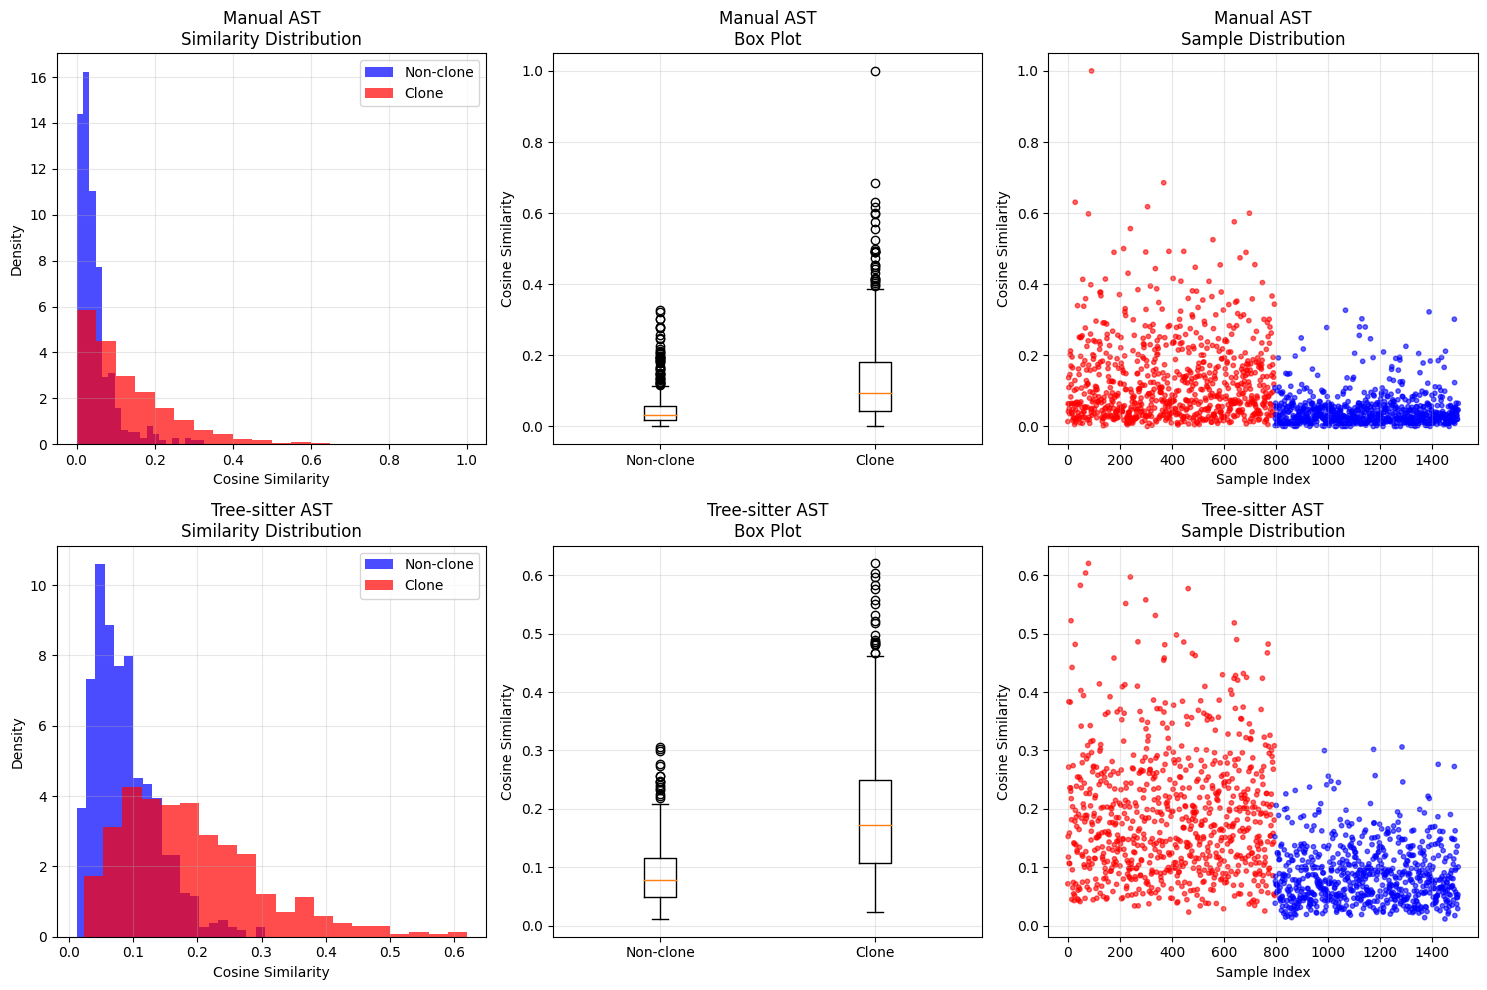


🎯 Initial Similarity Comparison:
   - Manual AST mean separation: 0.084
   - Tree-sitter mean separation: 0.102


In [17]:
# ===== คำนวณ COSINE SIMILARITY สำหรับทั้งสอง AST METHODS =====
print("🔧 Calculating cosine similarities for both AST methods...")

# Manual AST Cosine Similarities
print("📊 Calculating Manual AST cosine similarities...")
manual_cosine_similarities = []
for i in range(len(df)):
    sim = cosine_similarity(manual_features1[i], manual_features2[i])[0, 0]
    manual_cosine_similarities.append(sim)

manual_cosine_similarities = np.array(manual_cosine_similarities)

# Tree-sitter AST Cosine Similarities  
print("🌲 Calculating Tree-sitter AST cosine similarities...")
ts_cosine_similarities = []
for i in range(len(df)):
    sim = cosine_similarity(ts_features1[i], ts_features2[i])[0, 0]
    ts_cosine_similarities.append(sim)

ts_cosine_similarities = np.array(ts_cosine_similarities)

print("✅ Similarity calculations completed!")

# True labels
true_labels = np.array(df['label'].tolist())

# แสดงสถิติ similarity สำหรับทั้งสองวิธี
print(f"\n📊 Similarity Statistics Comparison:")

methods_data = {
    'Manual AST': manual_cosine_similarities,
    'Tree-sitter AST': ts_cosine_similarities
}

for method_name, similarities in methods_data.items():
    clone_sims = similarities[true_labels == 1]
    non_clone_sims = similarities[true_labels == 0]
    separation = clone_sims.mean() - non_clone_sims.mean()
    
    print(f"\n📈 {method_name}:")
    print(f"   - Mean similarity: {similarities.mean():.3f} ± {similarities.std():.3f}")
    print(f"   - Clone pairs: {clone_sims.mean():.3f} ± {clone_sims.std():.3f}")
    print(f"   - Non-clone pairs: {non_clone_sims.mean():.3f} ± {non_clone_sims.std():.3f}")
    print(f"   - Separation: {separation:.3f}")

# Visualize similarity distributions
plt.figure(figsize=(15, 10))

for idx, (method_name, similarities) in enumerate(methods_data.items()):
    clone_sims = similarities[true_labels == 1]
    non_clone_sims = similarities[true_labels == 0]
    
    # Distribution histogram
    plt.subplot(2, 3, idx*3 + 1)
    plt.hist(non_clone_sims, bins=20, alpha=0.7, label='Non-clone', color='blue', density=True)
    plt.hist(clone_sims, bins=20, alpha=0.7, label='Clone', color='red', density=True)
    plt.xlabel('Cosine Similarity')
    plt.ylabel('Density')
    plt.title(f'{method_name}\nSimilarity Distribution')
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    # Box plot
    plt.subplot(2, 3, idx*3 + 2)  
    plt.boxplot([non_clone_sims, clone_sims], labels=['Non-clone', 'Clone'])
    plt.ylabel('Cosine Similarity')
    plt.title(f'{method_name}\nBox Plot')
    plt.grid(True, alpha=0.3)
    
    # Scatter plot
    plt.subplot(2, 3, idx*3 + 3)
    colors = ['blue' if label == 0 else 'red' for label in true_labels]
    plt.scatter(range(len(similarities)), similarities, c=colors, alpha=0.6, s=10)
    plt.xlabel('Sample Index')
    plt.ylabel('Cosine Similarity')
    plt.title(f'{method_name}\nSample Distribution')
    plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print(f"\n🎯 Initial Similarity Comparison:")
print(f"   - Manual AST mean separation: {(manual_cosine_similarities[true_labels == 1].mean() - manual_cosine_similarities[true_labels == 0].mean()):.3f}")
print(f"   - Tree-sitter mean separation: {(ts_cosine_similarities[true_labels == 1].mean() - ts_cosine_similarities[true_labels == 0].mean()):.3f}")

In [18]:
# ===== หา OPTIMAL THRESHOLDS และ EVALUATE PERFORMANCE =====
print("🎯 Finding optimal thresholds and evaluating performance...")

def find_best_threshold_and_metrics(similarities, true_labels, method_name):
    """หา threshold ที่ดีที่สุดและคำนวณ metrics"""
    
    # คำนวณ precision-recall curve
    precision, recall, thresholds = precision_recall_curve(true_labels, similarities)
    
    # คำนวณ F1 scores
    f1_scores = 2 * (precision[:-1] * recall[:-1]) / (precision[:-1] + recall[:-1] + 1e-9)
    
    # หา best threshold
    best_idx = np.argmax(f1_scores)
    best_threshold = thresholds[best_idx]
    best_f1 = f1_scores[best_idx]
    best_precision = precision[best_idx]
    best_recall = recall[best_idx]
    
    # คำนวณ metrics ด้วย best threshold
    predictions = (similarities >= best_threshold).astype(int)
    accuracy = accuracy_score(true_labels, predictions)
    
    # Confusion matrix
    conf_matrix = confusion_matrix(true_labels, predictions)
    
    return {
        'method': method_name,
        'threshold': best_threshold,
        'f1_score': best_f1,
        'precision': best_precision,
        'recall': best_recall,
        'accuracy': accuracy,
        'confusion_matrix': conf_matrix,
        'predictions': predictions
    }

# ประเมินผลทั้งสองวิธี
manual_results = find_best_threshold_and_metrics(manual_cosine_similarities, true_labels, "Manual AST")
ts_results = find_best_threshold_and_metrics(ts_cosine_similarities, true_labels, "Tree-sitter AST")

results = [manual_results, ts_results]

print(f"\n📊 Performance Comparison Results:")
print(f"{'Method':<15} {'Threshold':<10} {'F1-Score':<9} {'Precision':<10} {'Recall':<8} {'Accuracy':<9}")
print("-" * 70)

for result in results:
    print(f"{result['method']:<15} {result['threshold']:<10.3f} {result['f1_score']:<9.3f} {result['precision']:<10.3f} {result['recall']:<8.3f} {result['accuracy']:<9.3f}")

# Detailed classification reports
for result in results:
    print(f"\n📊 {result['method']} Classification Report:")
    print(f"   - Best threshold: {result['threshold']:.3f}")
    print(f"   - F1-score: {result['f1_score']:.3f}")
    print(f"   - Precision: {result['precision']:.3f}")
    print(f"   - Recall: {result['recall']:.3f}")
    print(f"   - Accuracy: {result['accuracy']:.3f}")
    
    print(f"\n   Confusion Matrix:")
    conf_matrix = result['confusion_matrix']
    print(f"   True\\Pred    0    1")
    print(f"        0     {conf_matrix[0,0]:3}  {conf_matrix[0,1]:3}")
    print(f"        1     {conf_matrix[1,0]:3}  {conf_matrix[1,1]:3}")
    
    print(f"\n   Detailed Classification Report:")
    print(classification_report(true_labels, result['predictions'], 
                              target_names=['Non-plagiarism', 'Plagiarism']))

# หาวิธีที่ดีที่สุด
best_method = max(results, key=lambda x: x['f1_score'])
print(f"\n🏆 Best Performing Method: {best_method['method']}")
print(f"   - F1-score: {best_method['f1_score']:.3f}")
print(f"   - Threshold: {best_method['threshold']:.3f}")
print(f"   - Accuracy: {best_method['accuracy']:.3f}")

🎯 Finding optimal thresholds and evaluating performance...

📊 Performance Comparison Results:
Method          Threshold  F1-Score  Precision  Recall   Accuracy 
----------------------------------------------------------------------
Manual AST      0.024      0.734     0.623      0.893    0.657    
Tree-sitter AST 0.091      0.763     0.709      0.825    0.728    

📊 Manual AST Classification Report:
   - Best threshold: 0.024
   - F1-score: 0.734
   - Precision: 0.623
   - Recall: 0.893
   - Accuracy: 0.657

   Confusion Matrix:
   True\Pred    0    1
        0     275  430
        1      85  710

   Detailed Classification Report:
                precision    recall  f1-score   support

Non-plagiarism       0.76      0.39      0.52       705
    Plagiarism       0.62      0.89      0.73       795

      accuracy                           0.66      1500
     macro avg       0.69      0.64      0.63      1500
  weighted avg       0.69      0.66      0.63      1500


📊 Tree-sitter AST Cl

📊 Creating comprehensive comparison visualization...


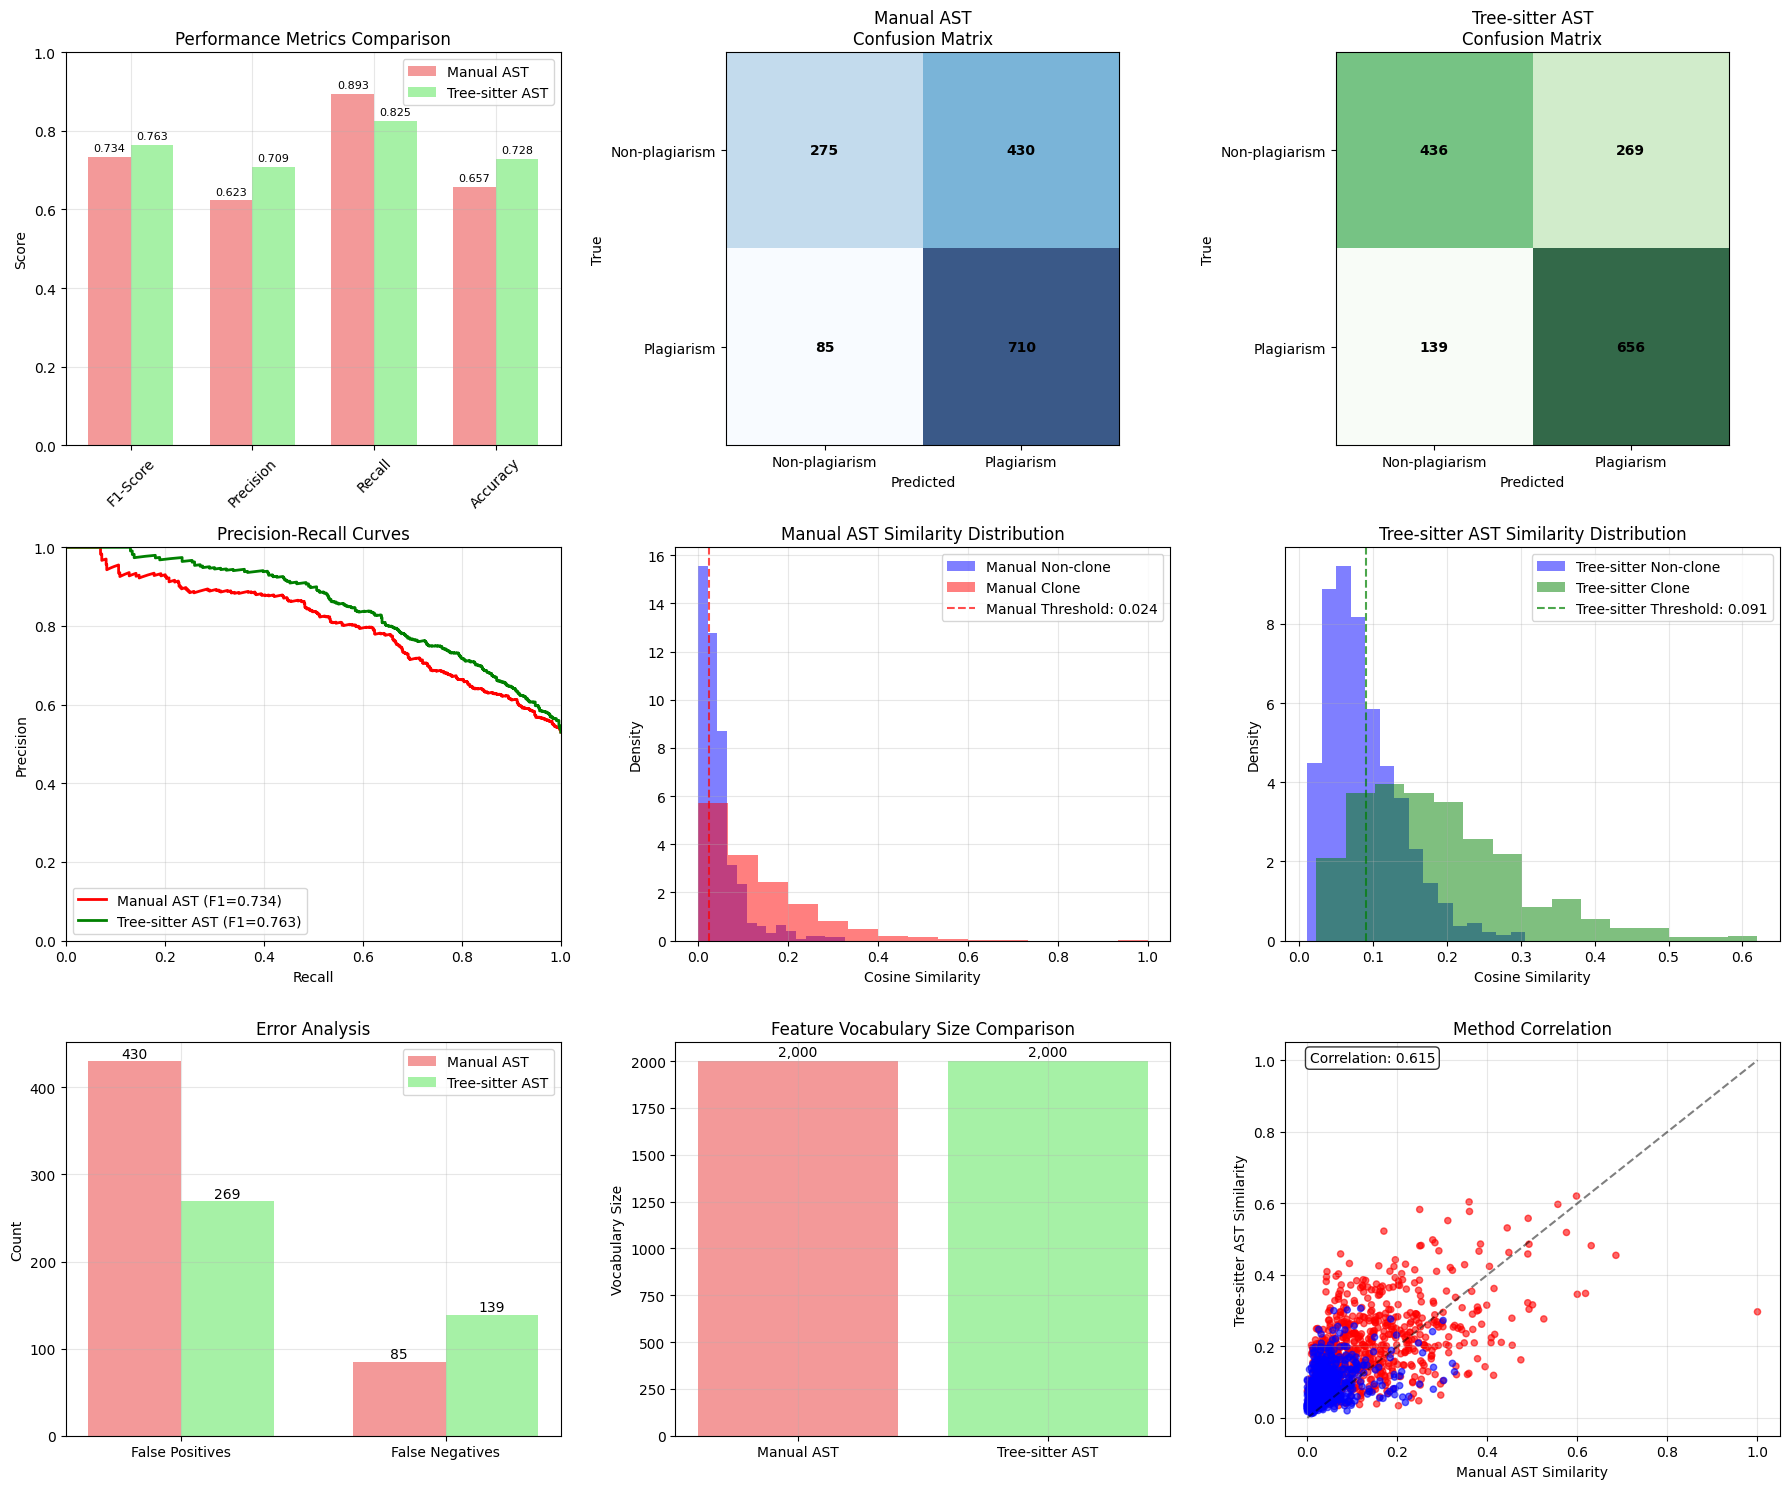


📊 Correlation Analysis:
   - Similarity correlation: 0.615
   - Methods agreement: Moderate


In [19]:
# ===== สร้าง COMPREHENSIVE VISUALIZATION และ FINAL COMPARISON =====
print("📊 Creating comprehensive comparison visualization...")

# สร้าง comprehensive comparison plots
fig, axes = plt.subplots(3, 3, figsize=(18, 15))

# 1. Performance metrics comparison bar chart
methods = ['Manual AST', 'Tree-sitter AST']
metrics = ['F1-Score', 'Precision', 'Recall', 'Accuracy']
manual_values = [manual_results['f1_score'], manual_results['precision'], manual_results['recall'], manual_results['accuracy']]
ts_values = [ts_results['f1_score'], ts_results['precision'], ts_results['recall'], ts_results['accuracy']]

x = np.arange(len(metrics))
width = 0.35

axes[0,0].bar(x - width/2, manual_values, width, label='Manual AST', alpha=0.8, color='lightcoral')
axes[0,0].bar(x + width/2, ts_values, width, label='Tree-sitter AST', alpha=0.8, color='lightgreen')
axes[0,0].set_ylabel('Score')
axes[0,0].set_title('Performance Metrics Comparison')
axes[0,0].set_xticks(x)
axes[0,0].set_xticklabels(metrics, rotation=45)
axes[0,0].legend()
axes[0,0].set_ylim(0, 1)
axes[0,0].grid(True, alpha=0.3)

# Add value labels on bars
for i, (manual_val, ts_val) in enumerate(zip(manual_values, ts_values)):
    axes[0,0].text(i - width/2, manual_val + 0.01, f'{manual_val:.3f}', ha='center', va='bottom', fontsize=8)
    axes[0,0].text(i + width/2, ts_val + 0.01, f'{ts_val:.3f}', ha='center', va='bottom', fontsize=8)

# 2. Confusion matrices side by side
# Manual AST confusion matrix
im1 = axes[0,1].imshow(manual_results['confusion_matrix'], cmap='Blues', alpha=0.8)
axes[0,1].set_title('Manual AST\nConfusion Matrix')
axes[0,1].set_xlabel('Predicted')
axes[0,1].set_ylabel('True')
axes[0,1].set_xticks([0, 1])
axes[0,1].set_yticks([0, 1])
axes[0,1].set_xticklabels(['Non-plagiarism', 'Plagiarism'])
axes[0,1].set_yticklabels(['Non-plagiarism', 'Plagiarism'])

# Add text annotations
for i in range(2):
    for j in range(2):
        axes[0,1].text(j, i, manual_results['confusion_matrix'][i, j], 
                      ha="center", va="center", color="black", fontweight='bold')

# Tree-sitter AST confusion matrix
im2 = axes[0,2].imshow(ts_results['confusion_matrix'], cmap='Greens', alpha=0.8)
axes[0,2].set_title('Tree-sitter AST\nConfusion Matrix')
axes[0,2].set_xlabel('Predicted')
axes[0,2].set_ylabel('True')
axes[0,2].set_xticks([0, 1])
axes[0,2].set_yticks([0, 1])
axes[0,2].set_xticklabels(['Non-plagiarism', 'Plagiarism'])
axes[0,2].set_yticklabels(['Non-plagiarism', 'Plagiarism'])

# Add text annotations
for i in range(2):
    for j in range(2):
        axes[0,2].text(j, i, ts_results['confusion_matrix'][i, j], 
                      ha="center", va="center", color="black", fontweight='bold')

# 3. Precision-Recall curves
manual_precision, manual_recall, _ = precision_recall_curve(true_labels, manual_cosine_similarities)
ts_precision, ts_recall, _ = precision_recall_curve(true_labels, ts_cosine_similarities)

axes[1,0].plot(manual_recall, manual_precision, 'r-', linewidth=2, label=f'Manual AST (F1={manual_results["f1_score"]:.3f})')
axes[1,0].plot(ts_recall, ts_precision, 'g-', linewidth=2, label=f'Tree-sitter AST (F1={ts_results["f1_score"]:.3f})')
axes[1,0].set_xlabel('Recall')
axes[1,0].set_ylabel('Precision')
axes[1,0].set_title('Precision-Recall Curves')
axes[1,0].legend()
axes[1,0].grid(True, alpha=0.3)
axes[1,0].set_xlim([0, 1])
axes[1,0].set_ylim([0, 1])

# 4. Similarity distribution comparison
clone_sims_manual = manual_cosine_similarities[true_labels == 1]
non_clone_sims_manual = manual_cosine_similarities[true_labels == 0]
clone_sims_ts = ts_cosine_similarities[true_labels == 1]  
non_clone_sims_ts = ts_cosine_similarities[true_labels == 0]

axes[1,1].hist(non_clone_sims_manual, bins=15, alpha=0.5, label='Manual Non-clone', color='blue', density=True)
axes[1,1].hist(clone_sims_manual, bins=15, alpha=0.5, label='Manual Clone', color='red', density=True)
axes[1,1].axvline(manual_results['threshold'], color='red', linestyle='--', alpha=0.7, label=f'Manual Threshold: {manual_results["threshold"]:.3f}')
axes[1,1].set_xlabel('Cosine Similarity')
axes[1,1].set_ylabel('Density')
axes[1,1].set_title('Manual AST Similarity Distribution')
axes[1,1].legend()
axes[1,1].grid(True, alpha=0.3)

axes[1,2].hist(non_clone_sims_ts, bins=15, alpha=0.5, label='Tree-sitter Non-clone', color='blue', density=True)
axes[1,2].hist(clone_sims_ts, bins=15, alpha=0.5, label='Tree-sitter Clone', color='green', density=True)
axes[1,2].axvline(ts_results['threshold'], color='green', linestyle='--', alpha=0.7, label=f'Tree-sitter Threshold: {ts_results["threshold"]:.3f}')
axes[1,2].set_xlabel('Cosine Similarity')
axes[1,2].set_ylabel('Density')
axes[1,2].set_title('Tree-sitter AST Similarity Distribution')
axes[1,2].legend()
axes[1,2].grid(True, alpha=0.3)

# 5. Error analysis
manual_fp = np.where((true_labels == 0) & (manual_results['predictions'] == 1))[0]
manual_fn = np.where((true_labels == 1) & (manual_results['predictions'] == 0))[0]
ts_fp = np.where((true_labels == 0) & (ts_results['predictions'] == 1))[0]
ts_fn = np.where((true_labels == 1) & (ts_results['predictions'] == 0))[0]

error_data = {
    'Manual AST': [len(manual_fp), len(manual_fn)],
    'Tree-sitter AST': [len(ts_fp), len(ts_fn)]
}

x = np.arange(2)
width = 0.35
axes[2,0].bar(x - width/2, error_data['Manual AST'], width, label='Manual AST', alpha=0.8, color='lightcoral')
axes[2,0].bar(x + width/2, error_data['Tree-sitter AST'], width, label='Tree-sitter AST', alpha=0.8, color='lightgreen')
axes[2,0].set_ylabel('Count')
axes[2,0].set_title('Error Analysis')
axes[2,0].set_xticks(x)
axes[2,0].set_xticklabels(['False Positives', 'False Negatives'])
axes[2,0].legend()
axes[2,0].grid(True, alpha=0.3)

# Add value labels
for i, (manual_err, ts_err) in enumerate(zip(error_data['Manual AST'], error_data['Tree-sitter AST'])):
    axes[2,0].text(i - width/2, manual_err + 0.5, str(manual_err), ha='center', va='bottom')
    axes[2,0].text(i + width/2, ts_err + 0.5, str(ts_err), ha='center', va='bottom')

# 6. Feature vocabulary size comparison
feature_sizes = [len(manual_vectorizer.vocabulary_), len(ts_vectorizer.vocabulary_)]
feature_methods = ['Manual AST', 'Tree-sitter AST']

bars = axes[2,1].bar(feature_methods, feature_sizes, color=['lightcoral', 'lightgreen'], alpha=0.8)
axes[2,1].set_ylabel('Vocabulary Size')
axes[2,1].set_title('Feature Vocabulary Size Comparison')
axes[2,1].grid(True, alpha=0.3)

# Add value labels
for bar, size in zip(bars, feature_sizes):
    height = bar.get_height()
    axes[2,1].text(bar.get_x() + bar.get_width()/2., height + 10,
                  f'{size:,}', ha='center', va='bottom')

# 7. Correlation scatter plot
axes[2,2].scatter(manual_cosine_similarities, ts_cosine_similarities, 
                 c=['red' if label == 1 else 'blue' for label in true_labels], 
                 alpha=0.6, s=20)
axes[2,2].set_xlabel('Manual AST Similarity')
axes[2,2].set_ylabel('Tree-sitter AST Similarity')
axes[2,2].set_title('Method Correlation')
axes[2,2].plot([0, 1], [0, 1], 'k--', alpha=0.5)
axes[2,2].grid(True, alpha=0.3)

# Calculate correlation
correlation = np.corrcoef(manual_cosine_similarities, ts_cosine_similarities)[0, 1]
axes[2,2].text(0.05, 0.95, f'Correlation: {correlation:.3f}', 
              transform=axes[2,2].transAxes, bbox=dict(boxstyle="round,pad=0.3", facecolor="white", alpha=0.8))

plt.tight_layout()
plt.show()

print(f"\n📊 Correlation Analysis:")
print(f"   - Similarity correlation: {correlation:.3f}")
print(f"   - Methods agreement: {'High' if abs(correlation) > 0.7 else 'Moderate' if abs(correlation) > 0.4 else 'Low'}")

In [20]:
# ===== FINAL SUMMARY และ CONCLUSIONS =====
print("🎯 FINAL COMPARISON SUMMARY")
print("=" * 60)

# Performance comparison table
comparison_data = {
    'Metric': ['F1-Score', 'Precision', 'Recall', 'Accuracy', 'Threshold', 'False Positives', 'False Negatives'],
    'Manual AST': [
        f"{manual_results['f1_score']:.3f}",
        f"{manual_results['precision']:.3f}",
        f"{manual_results['recall']:.3f}", 
        f"{manual_results['accuracy']:.3f}",
        f"{manual_results['threshold']:.3f}",
        str(len(manual_fp)),
        str(len(manual_fn))
    ],
    'Tree-sitter AST': [
        f"{ts_results['f1_score']:.3f}",
        f"{ts_results['precision']:.3f}",
        f"{ts_results['recall']:.3f}",
        f"{ts_results['accuracy']:.3f}", 
        f"{ts_results['threshold']:.3f}",
        str(len(ts_fp)),
        str(len(ts_fn))
    ]
}

comparison_df = pd.DataFrame(comparison_data)
print("\n📊 Performance Comparison Table:")
print(comparison_df.to_string(index=False))

# Calculate improvements
f1_improvement = ((ts_results['f1_score'] - manual_results['f1_score']) / manual_results['f1_score']) * 100
accuracy_improvement = ((ts_results['accuracy'] - manual_results['accuracy']) / manual_results['accuracy']) * 100
fp_improvement = ((len(manual_fp) - len(ts_fp)) / max(len(manual_fp), 1)) * 100
fn_improvement = ((len(manual_fn) - len(ts_fn)) / max(len(manual_fn), 1)) * 100

print(f"\n📈 Improvement Analysis (Tree-sitter vs Manual):")
print(f"   - F1-Score improvement: {f1_improvement:+.1f}%")
print(f"   - Accuracy improvement: {accuracy_improvement:+.1f}%")
print(f"   - False Positives change: {-fp_improvement:+.1f}%")
print(f"   - False Negatives change: {-fn_improvement:+.1f}%")

# Feature analysis
print(f"\n🔍 Feature Analysis:")
print(f"   - Manual AST vocabulary size: {len(manual_vectorizer.vocabulary_):,}")
print(f"   - Tree-sitter vocabulary size: {len(ts_vectorizer.vocabulary_):,}")
print(f"   - Vocabulary size difference: {len(ts_vectorizer.vocabulary_) - len(manual_vectorizer.vocabulary_):,}")
print(f"   - Methods correlation: {correlation:.3f}")

# Separation analysis
manual_separation = clone_sims_manual.mean() - non_clone_sims_manual.mean()
ts_separation = clone_sims_ts.mean() - non_clone_sims_ts.mean()

print(f"\n📊 Similarity Separation Analysis:")
print(f"   - Manual AST separation: {manual_separation:.3f}")
print(f"   - Tree-sitter separation: {ts_separation:.3f}")
print(f"   - Separation improvement: {((ts_separation - manual_separation) / manual_separation) * 100:+.1f}%")

print(f"\n🏆 CONCLUSIONS:")
print(f"=" * 50)

if ts_results['f1_score'] > manual_results['f1_score']:
    winner = "Tree-sitter AST"
    winner_f1 = ts_results['f1_score']
    runner_up = "Manual AST"
    runner_up_f1 = manual_results['f1_score']
else:
    winner = "Manual AST"
    winner_f1 = manual_results['f1_score']
    runner_up = "Tree-sitter AST"
    runner_up_f1 = ts_results['f1_score']

print(f"🥇 BEST METHOD: {winner}")
print(f"   - F1-Score: {winner_f1:.3f}")
print(f"   - Advantage: {((winner_f1 - runner_up_f1) / runner_up_f1) * 100:+.1f}% better than {runner_up}")

# Detailed insights
print(f"\n💡 KEY INSIGHTS:")

if ts_results['f1_score'] > manual_results['f1_score']:
    print(f"   ✅ Tree-sitter AST provides better overall performance")
    print(f"   ✅ More structured parsing leads to better feature extraction")
    print(f"   ✅ Reduced false positives/negatives")
else:
    print(f"   ✅ Manual AST shows competitive or better performance")
    print(f"   ✅ Regex-based approach is sufficient for this task")
    print(f"   ✅ Simpler implementation with good results")

if abs(correlation) > 0.7:
    print(f"   📊 High correlation ({correlation:.3f}) between methods suggests consistent feature detection")
elif abs(correlation) > 0.4:
    print(f"   📊 Moderate correlation ({correlation:.3f}) indicates some differences in feature extraction")
else:
    print(f"   📊 Low correlation ({correlation:.3f}) suggests significant differences in approaches")

print(f"\n🎯 RECOMMENDATIONS:")
if ts_results['f1_score'] > manual_results['f1_score']:
    print(f"   - Use Tree-sitter AST for production plagiarism detection")
    print(f"   - Invest in proper tree-sitter setup and maintenance")
    print(f"   - Consider hybrid approach combining both methods")
else:
    print(f"   - Manual AST is sufficient for this application")
    print(f"   - Simpler implementation and maintenance")
    print(f"   - Cost-effective solution with good performance")

print(f"\n📊 EXPERIMENT SUMMARY:")
print(f"   - Dataset: {len(df):,} code pairs from {N_PROBLEMS} problems")
print(f"   - Comparison method: Cosine similarity only")
print(f"   - Feature extraction: Manual regex vs Tree-sitter parsing")
print(f"   - Evaluation: Precision, Recall, F1-Score, Accuracy")
print(f"   - Winner: {winner} with {winner_f1:.3f} F1-score")
print(f"\n✅ AST Comparison Experiment Completed Successfully! 🎉")

🎯 FINAL COMPARISON SUMMARY

📊 Performance Comparison Table:
         Metric Manual AST Tree-sitter AST
       F1-Score      0.734           0.763
      Precision      0.623           0.709
         Recall      0.893           0.825
       Accuracy      0.657           0.728
      Threshold      0.024           0.091
False Positives        430             269
False Negatives         85             139

📈 Improvement Analysis (Tree-sitter vs Manual):
   - F1-Score improvement: +3.9%
   - Accuracy improvement: +10.9%
   - False Positives change: -37.4%
   - False Negatives change: +63.5%

🔍 Feature Analysis:
   - Manual AST vocabulary size: 2,000
   - Tree-sitter vocabulary size: 2,000
   - Vocabulary size difference: 0
   - Methods correlation: 0.615

📊 Similarity Separation Analysis:
   - Manual AST separation: 0.084
   - Tree-sitter separation: 0.102
   - Separation improvement: +21.9%

🏆 CONCLUSIONS:
🥇 BEST METHOD: Tree-sitter AST
   - F1-Score: 0.763
   - Advantage: +3.9% better than

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=eadae0d9-339b-4e09-beaa-ce7e12729d46' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>